# Explainable Health Cost Prediction

_Andrew Lemke_

## Load Libraries and Files

The dataset information is contained in the datasheet written to accompany it.

### Imports

In [98]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import sklearn
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

### Loading and Processing Data

In [3]:
data_path = './data/medical_costs/insurance.csv'
raw_data = pd.read_csv(data_path)

In [4]:
raw_data.head(7)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
5,31,female,25.7,0,no,southeast,3756.62
6,46,female,33.4,1,no,southeast,8240.59


In order to use this data for machine learning, some changes need to be made. `sex` and `smoker` will need to become binary and `region` will be encoded as a 1-hot vector.

In [5]:
data = raw_data.copy(deep=True)

In [6]:
# make smoker and sex binary
data['is_smoker'] = (data['smoker'] == 'yes').astype(int)
data['is_male'] = (data['sex'] == 'male').astype(int)

In [7]:
# make regions 1hot
regions = list(data['region'].unique())
for region in regions:
    data[region] = (data['region'] == region).astype(int)

In [8]:
# drop the old columns
data.drop(
    labels=['sex', 'smoker', 'region'],
    axis=1,
    inplace=True
)

In [9]:
# reorder columns
new_col_order = ['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                 'southeast', 'northwest', 'northeast', 'expenses']
data = data[new_col_order]

## Determine the domain limits of the data

ML models behave poorly when predicting on inputs outside of their domain. Many times, modelers forget to create limits on the inputs to their models, which can cause performance degradation when at the borders of the training data domain, which can be hard to detect, and cause clearly wrong inputs when far outside the data domain.

A simple way to test if a new sample is not from the same domain is to check if each feature of that sample exists within some set confidence limit. This is a probability metric on each sample, so for some feature X, if a sample is 2 standard deviations away, then it has a X percent of being in the dataset. One can set their confidence level and proceed.

The problem with this method is that it assumes all features are independent. One could come up with samples that are within the bounds of each individual features but are obviously out of domain

**picture of 2d "Y" shaped data showing this**

Consider a sample where the age is 18 and the number of kids is 5. Either one of those features is reasonable on its own, but put together, this sample is unlikely to belong to this data set.

Technically, this problem is called novelty detection, not outlier detection, but such nomenclature is only used when in discussion of the task. SKLearn provides a succinct explanation of the differences.

> **Outlier Detection:** The training data contains outliers which are defined as observations that are far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.
>
> **Novelty Detection:** The training data is not polluted by outliers and we are interested in detecting whether a new observation is an outlier. In this context an outlier is also called a novelty.



### Using SkLearn's Local Outlier Prediction Algorithm for Novelty Prediction

This model works by examining the distance to neighbors in the dataset. It uses the distance from a new point to points provided to output a novelty score.




In [15]:
clf = LocalOutlierFactor(
    algorithm='auto',  # automatically determine the best algorithm (other than brute force) to find neighbors
    novelty=True,  # predict novelty not outlier
    contamination=0.0001,  # we know all samples in dataset are part of distro, feature must be (0, 0.5]
)

In [16]:
# we want to remove the 'y' variable from the data to train this 
#  as new instances will only contain features used to predict it
X_novelty = data[['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                  'southeast', 'northwest', 'northeast']]

In [25]:
clf.fit(X_novelty)

LocalOutlierFactor(contamination=0.0001, novelty=True)

Now, for a quick demo of the outlier detection.

In [18]:
data.describe()

,age,is_male,bmi,children,is_smoker,southwest,southeast,northwest,northeast,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.665471,1.094918,0.204783,0.242900,0.272048,0.242900,0.242152,13270.422414
std,14.049960,0.500160,6.098382,1.205493,0.403694,0.428995,0.445181,0.428995,0.428546,12110.011240
min,18.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1121.870000
25%,27.000000,0.000000,26.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4740.287500
50%,39.000000,1.000000,30.400000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9382.030000
75%,51.000000,1.000000,34.700000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,16639.915000
max,64.000000,1.000000,53.100000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,63770.430000


In [52]:
# make some test points
X_outlier_demo = pd.DataFrame(
    data={
        'age': [33, 15, 95, 53, 18, ],
        'is_male': [1, 0, 0, 1, 0, ],
        'bmi': [40.04, 26.01, 26.99, 55.04, 32.59],
        'children': [3, 0, 0, 4, 0, ],
        'is_smoker': [0, 0, 0, 1, 0, ],
        'southwest': [1, 0, 0, 0, 1, ],
        'southeast': [0, 0, 1, 0, 0, ],
        'northwest': [0, 1, 0, 0, 0, ],
        'northeast': [0, 0, 0, 1, 0, ],
    }
)

demo_answers = [1, -1, -1, -1, 1]

In [44]:
X_outlier_demo

,age,is_male,bmi,children,is_smoker,southwest,southeast,northwest,northeast
0,33,1,40.04,3,0,1,0,0,0
1,15,0,26.01,0,0,0,0,1,0
2,95,0,26.99,0,0,0,1,0,0
3,53,1,55.04,4,1,0,0,0,1
4,18,0,32.59,0,0,1,0,0,0


In [45]:
clf.decision_function(X_outlier_demo)

X does not have valid feature names, but LocalOutlierFactor was fitted with feature names


array([ 1.47558617,  0.98608797, -6.30600359,  0.53455332,  1.53696613])

Warning is a consequence of using data frames as when operating, the model extracts the data before proceeding, so the model does not see the features of the new X when predicting.

As informed by the SKLearn documentation, "negative scores represent outliers, positive scores represent inliers." While this model easily spotted the age way larger than previously seen, it fails to recognize the hard minimum of 18 in the data. We can  see the problem with an ML only approach. 

This flaw makes us adopt a hybrid rules-based ML approach (TODO find the actual words for this from notes/slides). We will use rules to enforce certain in domain/out of domain decisions. The rules section will operate as a black list, meaning if a sample passes the rules, then it is sent to the model; if a sample fails the rules, then it is classified as out of domain.

Notice that this is different than input validation. Input validation guarantees that the input is not illogical. Novelty detection tests if the input is part of the distribution or not. Here is an example

```
features: ... southwest 	southeast 	northwest 	northeast
data:     ...     1             1           0           0
```

The above input would be caught by input validation, which would test to make sure the person is only living in 1 region.

```
features: ... is_male 	bmi 	children ...
data:     ...    1     04.77        2
```

In contrast, the above error cannot be caught by validation. The value of bmi is "legal" but not within the data distribution.


### Using SkLearn's 1-class SVM Algorithm for Novelty Prediction

For completeness sake, we will show one more novelty detection algorithm. This algorithm fits an SVM to the data. This is made possible by making the 1 class problem into a 2 class problem. The SVM's decision boundary occurs between the data and the origin, and uses a parameter in training to control how tightly to envelope the data, essentially, what tolerance to use when predicting the novelty of new samples. Using an rbf kernel removes the linear constraints from the model.


In [61]:
clf_1cSVM = OneClassSVM(
    kernel='rbf',
    nu=0.1,  # tolerance for novelty
    cache_size=400,
)

In [62]:
clf_1cSVM.fit(X_novelty)

OneClassSVM(cache_size=400, nu=0.1)

In [63]:
clf_1cSVM.decision_function(X_outlier_demo)

array([  8.57613997,  -3.4292507 , -47.1914073 , -11.78455482,
         0.70764446])

For this problem, the 1-class SVM works well, but we cannot rely just on this ML model as we can make the domain checking more robust with a combination of rules and models.


### Rules Based Approach

In [74]:
def rules_based_in_domain_check(X):
    """
    Testest the input to verify it is in domain with rules.
    Outputs False for out of domain, True if the rules indicate it is not out of domain.
    Designed to be used before an ML based approach.
    
    X: a dataframe with the columns ['age', 'is_male', 'bmi', 'children', 
       'is_smoker',  'southwest', 'southeast', 'northwest', 'northeast']
    """
    
    results1 = X['age'] >= 18
    results2 = X['children'] <= 5
    results = results1 & results2
    
    # convert to ints
    #results = (results.astype(int) * 2) - 1
    
    return results

In [82]:
rules_based_in_domain_check(X_outlier_demo)

0     True
1    False
2     True
3     True
4     True
dtype: bool

### Hybred Approach

Combintion of rules blacklisting and an ML novelty preditction

In [79]:
def in_domain_testing(X, ml_model=clf):
    rules_results = rules_based_domain_check(X)
    model_results = ml_model.decision_function(X) >= 0  # turn into T or F, T is in domain
    return rules_results & model_results
    
    

In [83]:
in_domain_testing(X_outlier_demo, ml_model=clf_1cSVM)

0     True
1    False
2    False
3    False
4     True
dtype: bool

We see that this combination of approaches works best to deal with hard, easily defined edges on the data domain that are human-informed, which is the 18+ restriction on the data, and the more complicated soft rules. This hybrid approach can be a good way to provide safeguards around your model. The blacklist rules approach can see usage in other cases where there might be some external limit on the model put in place by law or societal norms. An example of its use can be in a product recommendation model. Suppose that the local laws forbid targeted advertisement to those under 18 and you are writing an advertising model for social media. The model should use the profile information and a rules based approach to deal with this situation as the difference between 17 and 18 to a novelty detector is not significant, but the difference between 17 years old and 18 years old is.


## ML Model

The model development first partitions the data into train, validation, and test sets. Then, a variety of architectures are tested and the one with the best validation performance is chosen.


### Setting up the data

Since we are using torch, we will need a dataset and dataloader. Before creating those, we need to split the data into train, val, test.




In [88]:
train, test_val = sklearn.model_selection.train_test_split(
    data, 
    test_size=0.4, 
    random_state=21, 
    shuffle=True
)
val, test = sklearn.model_selection.train_test_split(
    test_val, 
    test_size=0.5, 
    random_state=21, 
    shuffle=True
)

Data normalization is crucial for getting useful gradients when training. 

In [99]:
# normalize the X data with a standard scaler.
standard_scaler = StandardScaler()

In [107]:
X_train = train[['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                  'southeast', 'northwest', 'northeast']]
X_val = val[['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                  'southeast', 'northwest', 'northeast']]
X_test = test[['age', 'is_male', 'bmi', 'children', 'is_smoker',  'southwest', 
                  'southeast', 'northwest', 'northeast']]
y_train = train[['expenses']].to_numpy() / 1000
y_val = val[['expenses']].to_numpy() / 1000
y_test = test[['expenses']].to_numpy() / 1000

In [108]:
standard_scaler.fit(X_train)

StandardScaler()

In [109]:
X_train_normed = standard_scaler.transform(X_train)
X_val_normed = standard_scaler.transform(X_val)
X_test_normed = standard_scaler.transform(X_test)


In [115]:
train_normed = np.concatenate((X_train_normed, y_train), axis=1)
val_normed = np.concatenate((X_val_normed, y_val), axis=1)
test_normed = np.concatenate((X_test_normed, y_test), axis=1)

#### Dataloader

torch's dataloader is provided as input to the dataset. The dataset enables parallelization of data queuing so the model can train rapidly. While the model is running, the datasets and dataloaders work to load the next few batches into memory so no time is wasted between batches.




In [145]:
class health_cost_dataset(Dataset):
    def __init__(self, data, transform=None):
        # data should be numpy array of shape (-1, 10)
        self.data = data.astype('float32')
        self.transform = transform
        self.length = len(data)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        item = self.data[index]
        if self.transform:
            item = transform(item)
        X = item[:9]
        y = item[9:]
        return X, y

### Creating the model

In [193]:
class health_cost_net(nn.Module):
    def __init__(self, hidden_layers=[]):
        super(health_cost_net, self).__init__()
        
        hiddens = hidden_layers.copy()
        self.input_size = 9
        self.output_size = 1
        hiddens.insert(0, self.input_size)
        hiddens.append(self.output_size)
        
        self.layers = nn.ModuleList()
        for k in range(len(hiddens)-1):
            self.layers.append(nn.Linear(hiddens[k], hiddens[k+1]))
            if k < len(hiddens)-2:
                self.layers.append(nn.ReLU())
        # final node output is predicted continuous output
        
    def forward(self, x):
        for f in self.layers:
            x = f(x)
        return x

def train(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model = model.float()
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 50 == 0 and verbose:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

def test(dataloader, model, loss_fn, verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model = model.float()
    model.eval()
    
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    if verbose:
        print(f"Results: \n Avg loss: {test_loss:>4f}")
    return  test_loss
    

In [194]:
health_cost_net(hidden_layers= [8, 6, 4])

health_cost_net(
  (layers): ModuleList(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)

## Training the net

In [195]:
train_dataset = health_cost_dataset(train_normed)
val_dataset = health_cost_dataset(val_normed)
test_dataset = health_cost_dataset(test_normed)

In [196]:
batch_size = 200

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = health_cost_net(hidden_layers= [8, 6, 4])
model = model.float()

# regression, typical choice is MSE
loss_fn = nn.MSELoss()

# adam is popular due to its grad boosting capabilities, 
#  and it includes momentum and weight punishing
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.01, 
    betas=(0.9, 0.999), 
    eps=1e-8, 
    weight_decay=0.005
)

train_loss = []
val_loss = []

epochs = 100
for t in range(epochs):
    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
    train_loss.append(train_l.detach().numpy())
    
    val_l = test(val_dataloader, model, loss_fn, verbose=False)
    val_loss.append(val_l)

    
print("Done training!")
print(f"End Loss:  {val_loss[-1]:>4f}")


Using cpu device
Done training!
End Loss:  38.554186


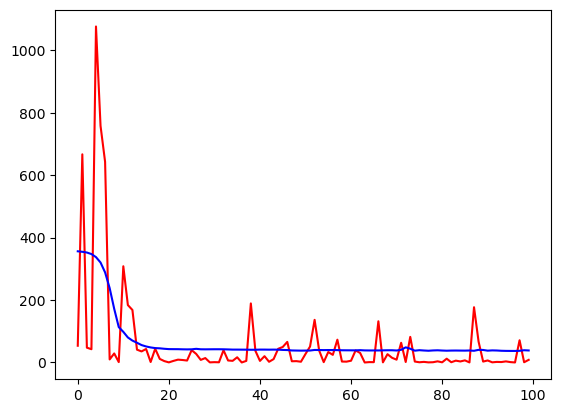

In [197]:
fig, ax = plt.subplots()

xs = np.arange(len(val_loss))
ax.plot(xs, train_loss, color='red')
ax.plot(xs, val_loss, color='blue')

plt.show()

In [216]:
seed = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



weight_decays = [0, 0.001, 0.01, 0.1]
lrs = [0.01, 0.1, 0.2]
hiddens = [
    [5, 3],
    [8, 6, 4],
    [8, 6, 6, 6, 4]
]

weight_decay_list = []
lr_list = []
hidden_layers_list = []
best_val_accur_list = []
best_val_accur_at_list = []

counter = 0
for h in hiddens:
    for lr in lrs:
        for wd in weight_decays:
            torch.manual_seed(seed)
            np.random.seed(seed)
            
            batch_size = 200

            train_dataloader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            )
            val_dataloader = DataLoader(
                val_dataset,
                batch_size=batch_size,
                shuffle=False
            )
            test_dataloader = DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
            
            init_hidden = h.copy()
            model = health_cost_net(hidden_layers=h)
            model = model.float()

            # regression, typical choice is MSE
            loss_fn = nn.MSELoss()

            # adam is popular due to its grad boosting capabilities, 
            #  and it includes momentum and weight punishing
            optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=lr, 
                betas=(0.9, 0.999), 
                eps=1e-8, 
                weight_decay=wd,
            )

            train_loss = []
            val_loss = []

            epochs = 100
            for t in range(epochs):
                train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
                train_loss.append(train_l.detach().numpy())

                val_l = test(val_dataloader, model, loss_fn, verbose=False)
                val_loss.append(val_l)


            #print("Done training!")
            #print(f"End Loss:  {val_loss[-1]:>4f}")
            
            best_val_loss = min(val_loss)
            best_val_loss_at = val_loss.index(best_val_loss)
            
            weight_decay_list.append(wd)
            lr_list.append(lr)
            hidden_layers_list.append(h) 
            best_val_accur_list.append(best_val_loss)
            best_val_accur_at_list.append(best_val_loss_at)
            
            if counter % 10 == 0:
                print('iteration {:>3}'.format(counter))
            counter += 1
            
results = pd.DataFrame(
    data={
        'hidden_layers': hidden_layers_list,
        'lr': lr_list,
        'weight_decay': weight_decay_list,
        'best_val_loss_at': best_val_accur_at_list,
        'best val loss': best_val_accur_list
    }
)

Using cpu device
iteration   0
iteration  10
iteration  20
iteration  30


In [217]:
results.sort_values(by='best val loss', ascending=True).head(10)

,hidden_layers,lr,weight_decay,best_val_loss_at,best val loss
17,"[8, 6, 4]",0.1,0.001,86,29.011810
18,"[8, 6, 4]",0.1,0.010,79,29.829028
16,"[8, 6, 4]",0.1,0.000,79,30.121391
29,"[8, 6, 6, 6, 4]",0.1,0.001,61,30.645989
22,"[8, 6, 4]",0.2,0.010,79,30.668508
34,"[8, 6, 6, 6, 4]",0.2,0.010,63,30.962824
21,"[8, 6, 4]",0.2,0.001,79,31.171957
20,"[8, 6, 4]",0.2,0.000,79,31.615526
23,"[8, 6, 4]",0.2,0.100,75,31.946862
19,"[8, 6, 4]",0.1,0.100,75,32.565205


The best model uses:

```
hidden layers: [8, 6, 4] 	
learning rate: 0.1
weight decay: 0.001
epoch: 86
anticipated loss: 29.011810
```

Now that we have the best hyperparameters, we can train the model and save it for future use.